<a href="https://colab.research.google.com/github/furtman/WQTC25_workshop_IMTR/blob/main/Ex_1/Src/wqtc_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMPORT SECTION

**Load required libraries for data processing, modelling, and visualization**

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt  # import core data science libraries
from sklearn.metrics import mean_squared_error as MSE  # import mean squared error metric
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HW  # import triple exponential smoothing
from statsmodels.tools.sm_exceptions import ConvergenceWarning  # import convergence warning class
import xgboost as xgb, warnings  # import xgboost and warnings modules
from scipy.optimize import minimize  # import optimization function
from mpl_toolkits.mplot3d import Axes3D  # import 3D plotting
from tqdm import tqdm  # import progress bar library for jupyter notebooks
warnings.simplefilter('ignore', ConvergenceWarning)  # suppress convergence warnings

# USER INPUTS

**STATIC INPUTS - These won't change for this exercise**

In [ ]:
DATA_PATH     = "wqtc.csv"  # path to the data file containing time series data
TIMESTAMP_COL = "Timestamp (Local)"  # name of the timestamp column in the .csv file
SPD           = 72  # seasonal period for triple exponential smoothing model (no. of 20-minute time stamps in a day)
TARGET        = "at7_nhx"  # target variable to predict (Aeration Tank 7 ammonia concentration)
AVG_INPUTS    = ["at4_nhx", "at6_nhx"]  # input variables for the simple average model

**DYNAMIC INPUTS - Feel free to modify these inputs within the stated bounds**

In [ ]:
PLOTS_ON            = True  # keep True except for scenario analysis
ROLL_WINDOW         = "120min"  # rolling window width for averaging DO concentrations (xgboost model); BOUNDS = "60min" - "180min"
TRAINING_WINDOW     = 3  # number of days of training data to use before an evaluation day; BOUNDS = 2-14
NORMAL_DEF_WINDOW   = 3  # number of days to use before an evaluation day to define normal model performance; BOUNDS = 1-10
FAULT_DAY           = 25  # single fault day for comparison with normal operation; ENTER EITHER 25 OR 26

In [ ]:
# Model enable/disable flags (1 = enabled, 0 = disabled)
ENABLE_TOD_MEDIAN    = 1  # Univariate: TOD median (time-of-day baseline model)
ENABLE_TES           = 1  # Univariate: TES (triple exponential smoothing forecasting)
ENABLE_AVG_INPUTS    = 1  # Multivariate: avg(at4_nhx, at6_nhx) (simple multivariate model)
ENABLE_XGBOOST       = 1  # Multivariate: XGBoost (advanced machine learning model)
ENABLE_ENSEMBLE      = 1  # Ensemble (optimized weighted combination of all models)

#FUNCTIONS

##UNIVARIATE MODEL FUNCTIONS

**These are models that use only the target variable for prediction**

In [ ]:
def tod_median(y, idx, spd=SPD):
    """Time-of-day median model: predicts based on historical median values for each time period."""
    m = 1440 // spd  # calculate timestamp separation
    g = ((y.index.hour*60 + y.index.minute) // m)  # define timestamp groups
    med = pd.Series(y.values).groupby(g).median().reindex(range(spd), fill_value=y.median())  # calculate median for each group
    return pd.Series(np.take(med.values, ((idx.hour*60 + idx.minute) // m)), index=idx)  # return median values with associated groups

In [ ]:
def tes(y, spd=SPD):
    """Triple Exponential Smoothing model: forecasts using trend and seasonal patterns."""
    y_freq = y.copy()  # copy the data to avoid modifying the original data
    freq = str(1440 // spd) + 'min'  # set 20-minute frequency for the time series
    y_freq.index.freq = pd.tseries.frequencies.to_offset(freq)  # add frequency information to avoid statsmodels warnings

    return HW(y_freq, trend="add", damped_trend=True, seasonal="add",
              seasonal_periods=spd, initialization_method="estimated").fit().forecast(spd)  # fit the model with additive trend/seasonality and forecast future values

##MULTIVARIATE MODEL FUNCTIONS

**These are models that use multiple input variables for prediction**

In [ ]:
def model_avg_inputs(te, avg_inputs):
    """Simple multivariate model using average of input variables."""
    return te[avg_inputs].mean(1)  # calculate row-wise mean of specified input variables

In [ ]:
def model_xgboost(tr, te, ytr, idx, roll_window):
    """Advanced multivariate XGBoost model using dissolved oxygen averages and flow rate."""
    u = pd.concat([tr, te]).sort_index()  # concatenate training and evaluation data for feature engineering
    X = pd.DataFrame({
        "z2": u["at7_z2_do"].rolling(roll_window, min_periods=1).mean(),  # rolling average of zone 2 DO
        "z3": u["at7_z3_do"].rolling(roll_window, min_periods=1).mean(),  # rolling average of zone 3 DO
        "q":  u["plant_inf_q"]  # plant influent flow rate
    })
    Xtr = X.loc[ytr.index].dropna(); ytra = ytr.loc[Xtr.index]  # extract training features and targets
    Xte = X.loc[idx].dropna()  # extract evaluation features

    xgb_model = xgb.XGBRegressor(
        n_estimators=50,  # number of trees
        max_depth=3,  # size of each tree
        learning_rate=0.1,  # learning rate
    )
    xgb_model.fit(Xtr.values, ytra.values)  # train the XGBoost model on training data

    preds = pd.Series(xgb_model.predict(Xte.values), index=Xte.index)  # make predictions on evaluation data

    return preds  # return predictions as pandas Series

##HELPER FUNCTIONS

**The next two functions help us evaluate model performance**

In [ ]:
def model_err(yte, prediction, model_name, preds_dict, pred_key):
    """Helper function to evaluate a model and add results to lists."""
    yt, yhat = yte.align(prediction, join='inner')  # align the target and prediction data to common timestamps
    mse_value = MSE(yt, yhat)  # calculate mean squared error between actual and predicted values
    preds_dict[pred_key] = prediction  # add the prediction to the predictions dictionary for plotting
    return (model_name, mse_value)  # return model name and mse for results dataframe

In [ ]:
def eval_day_perf(df, dn, spd=SPD, target=TARGET, avg_inputs=AVG_INPUTS, roll_window=ROLL_WINDOW, training_window=TRAINING_WINDOW):
    """Evaluate all enabled models for a specific day using specified number of training days."""
    tr = df[(df["__day__"]>=dn-training_window)&(df["__day__"]<=dn-1)]  # training data: specified days before evaluation day
    te = df[df["__day__"]==dn]  # evaluation data: the specific day being evaluated
    ytr, yte, idx = tr[target].dropna(), te[target].dropna(), te.index  # extract target values and evaluation timestamps
    res, preds = [], {}  # initialize results list and predictions dictionary

    # Univariate: TOD median (time-of-day baseline model)
    if ENABLE_TOD_MEDIAN:
        p_tod = tod_median(ytr, idx, spd)  # generate time-of-day median predictions
        res.append(model_err(yte, p_tod, "Univariate: TOD median", preds, "TOD median"))  # evaluate and store results

    # Univariate: TES (triple exponential smoothing forecasting model)
    if ENABLE_TES:
        p_tes = pd.Series(np.asarray(tes(ytr, spd)).ravel(), index=idx)  # generate TES predictions
        res.append(model_err(yte, p_tes, "Univariate: TES", preds, "TES"))  # evaluate and store results

    # Multivariate: avg(at4_nhx, at6_nhx) (simple average of input variables)
    if ENABLE_AVG_INPUTS:
        p_avg = model_avg_inputs(te, avg_inputs)  # generate average input predictions
        res.append(model_err(yte, p_avg, "Multivariate: avg(at4_nhx, at6_nhx)", preds, "avg(at4,at6)"))  # evaluate and store results

    # Multivariate: XGBoost (advanced machine learning model with DO and flow features)
    if ENABLE_XGBOOST:
        p_xgb = model_xgboost(tr, te, ytr, idx, roll_window)  # generate XGBoost predictions
        res.append(model_err(yte, p_xgb, "Multivariate: XGBoost", preds, "XGBoost (DO 2h + q)"))  # evaluate and store results

    return pd.DataFrame(res, columns=["Model","MSE"]).sort_values("MSE", ascending=True, na_position="last"), preds, yte  # return sorted results, predictions, and targets

**The next functions pertain to the Ensemble Model, which is weighted combination of all models**

In [ ]:
def optimize_ensemble_weights(all_eval_results):
    """Optimize ensemble weights across all evaluation days to find one optimal set of weights."""
    all_predictions, all_targets = {}, {}  # initialize dictionaries to store predictions and targets
    for day_results in all_eval_results:  # iterate through each evaluation day
        preds_dict, yte = day_results['predictions'], day_results['target']  # extract predictions and targets for this day
        for name, pred in preds_dict.items():  # iterate through each model's predictions
            yt_aligned, pred_aligned = yte.align(pred, join='inner')  # align target and prediction timestamps
            if name not in all_predictions: all_predictions[name], all_targets[name] = [], []  # initialize lists for new models
            all_predictions[name].append(pred_aligned.values)  # add prediction values to list
            all_targets[name].append(yt_aligned.values)  # add target values to list

    preds = {name: np.concatenate(preds) for name, preds in all_predictions.items()}  # concatenate all days' predictions for each model
    targets = {name: np.concatenate(targets) for name, targets in all_targets.items()}  # concatenate all days' targets for each model

    def objective(weights):  # define objective function to minimize
        ensemble_pred = np.zeros(len(targets[list(targets.keys())[0]]))  # initialize ensemble prediction array
        for i, (name, pred_values) in enumerate(preds.items()):  # iterate through each model
            ensemble_pred += weights[i] * pred_values  # add weighted model prediction to ensemble
        return MSE(targets[list(targets.keys())[0]], ensemble_pred)  # return mse between ensemble prediction and targets

    result = minimize(objective, np.ones(len(preds))/len(preds), method='Nelder-Mead')  # optimize weights using Nelder-Mead method
    return result.x, list(preds.keys())  # return optimal weights and model names

In [ ]:
def create_ensemble_prediction(predictions_dict, weights, model_keys):
    """Create ensemble prediction using optimized weights for a specific day."""
    common_index = None  # initialize common index
    for key in model_keys:  # iterate through each model
        pred = predictions_dict[key]  # get model's predictions
        common_index = pred.index if common_index is None else common_index.intersection(pred.index)  # find intersection of timestamps

    ensemble_pred = pd.Series(0.0, index=common_index)  # initialize ensemble prediction series
    for i, key in enumerate(model_keys):  # iterate through each model
        ensemble_pred += weights[i] * predictions_dict[key].loc[common_index]  # add weighted model prediction to ensemble

    return ensemble_pred  # return final ensemble prediction

##VISUALIZATION FUNCTIONS

**Creates plots showing observed vs predicted values**

In [ ]:
def plot_day(dn, preds, y):
    """Create a plot showing observed data and all model predictions for a specific day."""
    plt.figure(figsize=(12,5))  # create figure with width=12, height=5 inches
    plt.scatter(y.index, y.values, label="Observed (at7_nhx)", alpha=0.7, s=20)  # plot observed data as scatter points

    if "Ensemble" in preds and len(preds["Ensemble"]):  # check if ensemble exists and has data
        plt.plot(preds["Ensemble"].index, preds["Ensemble"].values,
                label="Ensemble (Optimized)", linewidth=3, alpha=1.0, color='red')  # plot ensemble with thick red line

    for k,s in preds.items():  # iterate through each model's predictions
        if k != "Ensemble" and len(s):  # skip ensemble (already plotted) and empty series
            plt.plot(s.index, s.values, label=k, alpha=0.6, linewidth=1)  # plot model predictions as thin transparent lines

    plt.title(f"Observed vs Model Predictions — Day {dn}")  # set plot title with day number
    plt.xlabel("Time"); plt.ylabel("at7_nhx"); plt.legend(); plt.tight_layout()  # add labels, legend, adjust layout
    plt.show()  # display the plot

##MAIN EXECUTION FUNCTIONS

In [ ]:
def run():
    """Main function that loads data, evaluates models, optimizes ensemble, and generates results."""
    # # data loading and preprocessing
    df = pd.read_csv(DATA_PATH)  # load the csv data file
    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL])  # convert timestamp column to datetime format
    df = df.sort_values(TIMESTAMP_COL).set_index(TIMESTAMP_COL)  # sort by timestamp and set as index

    cols = [TARGET] + AVG_INPUTS + ["at7_z2_do","at7_z3_do","plant_inf_q"]  # list of columns to convert to numeric
    df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")  # convert specified columns to numeric, errors become NaN

    st = df.index[0].normalize()  # get the start date (normalized to midnight)
    df["__day__"] = (df.index.normalize() - st).days + 1  # add day number column (1, 2, 3, etc.)

    # # define normal days based on window before fault day
    normal_days = list(range(FAULT_DAY - NORMAL_DEF_WINDOW, FAULT_DAY))  # define normal days as t0 - x days
    print(f"Normal days: {normal_days} (t0 - {NORMAL_DEF_WINDOW} days)")  # print normal days information
    print(f"Fault day: {FAULT_DAY}")  # print fault day information

    # # model evaluation and ensemble optimization
    all_eval_data = [{'day': d, 'predictions': preds, 'target': y, 'mse': mse}  # create evaluation data dictionary
                     for d in normal_days + [FAULT_DAY]  # iterate through normal days and fault day
                     for mse, preds, y in [eval_day_perf(df, d)]]  # evaluate all models for this day

    # # optimize weights using only normal days (exclude fault day from optimization)
    normal_eval_data = [data for data in all_eval_data if data['day'] in normal_days]  # filter to normal days only
    weights, model_keys = optimize_ensemble_weights(normal_eval_data)  # find optimal weights across normal days only

    # # apply weights and create plots
    ensemble_results = []  # initialize list to store ensemble results
    for eval_data in all_eval_data:  # iterate through each evaluation day
        day_num, preds, yte = eval_data['day'], eval_data['predictions'], eval_data['target']  # extract day data
        ensemble_pred = create_ensemble_prediction(preds, weights, model_keys)  # create ensemble prediction
        ensemble_mse = MSE(*yte.align(ensemble_pred, join='inner'))  # calculate ensemble mse
        preds["Ensemble"] = ensemble_pred  # add ensemble to predictions dictionary
        if PLOTS_ON: plot_day(day_num, preds, yte)  # create and display plot for this day
        ensemble_results.append({'day': day_num, 'ensemble_mse': ensemble_mse})  # store ensemble results

    # # create summary tables
    print("\n=== ENSEMBLE WEIGHTS ===")  # print section header
    weights_df = pd.DataFrame({
        'Model': model_keys,  # model names
        'Weight': weights  # optimal weights
    }).sort_values('Weight', ascending=False)  # sort by weight (highest first)
    print(weights_df.round(4))  # print weights table with 4 decimal places

    print("\n=== MODEL PERFORMANCE SUMMARY ===")  # print section header
    # # collect all mses from individual models
    all_mse_data = []  # list to store all mse data
    for eval_data in all_eval_data:  # iterate through each evaluation day
        day_num = eval_data['day']  # get day number
        mse_df = eval_data['mse']  # get mse dataframe for this day
        for _, row in mse_df.iterrows():  # iterate through each model's mse
            all_mse_data.append({
                'Day': day_num,  # day number
                'Model': row['Model'],  # model name
                'MSE': row['MSE'],  # mse value
                'Type': 'Normal' if day_num in normal_days else 'Fault'  # classify as normal or fault day
            })

    # # add ensemble results to the data
    for result in ensemble_results:  # iterate through ensemble results
        all_mse_data.append({
            'Day': result['day'],  # day number
            'Model': 'Ensemble',  # model name
            'MSE': result['ensemble_mse'],  # ensemble mse
            'Type': 'Normal' if result['day'] in normal_days else 'Fault'  # classify as normal or fault day
        })

    mse_df = pd.DataFrame(all_mse_data)  # create dataframe from all mse data

    # # calculate performance summary statistics
    summary = mse_df.groupby(['Model', 'Type'])['MSE'].mean().unstack()  # group by model and type, calculate mean mse
    summary['Ratio'] = summary['Fault'] / summary['Normal']  # calculate fault/normal ratio for each model
    summary = summary.sort_values('Ratio', ascending=False)  # sort by ratio (highest first)

    print(summary.round(4))  # print performance summary with 4 decimal places

In [ ]:
# def grid_search():
#     """Perform grid search on training window and normal definition window parameters."""
#     # # define parameter ranges for grid search
#     training_windows = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]  # different training window sizes
#     normal_windows = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # different normal definition window sizes

#     results = []  # initialize results list

#     # # create progress bar for grid search
#     total_combinations = len(training_windows) * len(normal_windows)  # calculate total combinations
#     pbar = tqdm(total=total_combinations, desc="Grid Search Progress")  # create progress bar

#     for tw in training_windows:  # iterate through training windows
#         for nw in normal_windows:  # iterate through normal windows
#             pbar.set_description(f"Training Window: {tw}, Normal Window: {nw}")  # update progress bar description
#             # # temporarily modify global parameters
#             global TRAINING_WINDOW, NORMAL_DEF_WINDOW
#             TRAINING_WINDOW, NORMAL_DEF_WINDOW = tw, nw

#             # # run evaluation with current parameters
#             df = pd.read_csv(DATA_PATH)  # load data
#             df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL])  # convert timestamps
#             df = df.sort_values(TIMESTAMP_COL).set_index(TIMESTAMP_COL)  # sort and set index
#             cols = [TARGET] + AVG_INPUTS + ["at7_z2_do","at7_z3_do","plant_inf_q"]  # define columns
#             df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")  # convert to numeric
#             st = df.index[0].normalize()  # get start date
#             df["__day__"] = (df.index.normalize() - st).days + 1  # add day numbers

#             normal_days = list(range(FAULT_DAY - nw, FAULT_DAY))  # define normal days
#             all_eval_data = [{'day': d, 'predictions': preds, 'target': y, 'mse': mse}
#                              for d in normal_days + [FAULT_DAY]
#                              for mse, preds, y in [eval_day_perf(df, d, training_window=tw)]]

#             # # optimize weights using only normal days (exclude fault day from optimization)
#             normal_eval_data = [data for data in all_eval_data if data['day'] in normal_days]  # filter to normal days only
#             weights, model_keys = optimize_ensemble_weights(normal_eval_data)  # optimize weights
#             ensemble_results = []  # initialize ensemble results
#             for eval_data in all_eval_data:  # iterate through evaluation data
#                 day_num, preds, yte = eval_data['day'], eval_data['predictions'], eval_data['target']
#                 ensemble_pred = create_ensemble_prediction(preds, weights, model_keys)  # create ensemble
#                 ensemble_mse = MSE(*yte.align(ensemble_pred, join='inner'))  # calculate mse
#                 ensemble_results.append({'day': day_num, 'ensemble_mse': ensemble_mse})  # store results

#             # # calculate normal and fault mse averages
#             normal_mse = np.mean([r['ensemble_mse'] for r in ensemble_results if r['day'] in normal_days])  # average normal mse
#             fault_mse = np.mean([r['ensemble_mse'] for r in ensemble_results if r['day'] == FAULT_DAY])  # fault mse
#             ratio = fault_mse / normal_mse  # calculate ratio
#             composite_score = ratio / (normal_mse * fault_mse)  # composite metric: ratio / (normal_mse * fault_mse)

#             results.append({'Training_Window': tw, 'Normal_Window': nw, 'Normal_MSE': normal_mse, 'Fault_MSE': fault_mse, 'Ratio': ratio, 'Composite_Score': composite_score})  # store results
#             pbar.update(1)  # update progress bar

#     pbar.close()  # close progress bar

#     # # create results dataframe and find top 5 configurations
#     results_df = pd.DataFrame(results)  # create dataframe from results
#     top_5_configs = results_df.nlargest(5, 'Composite_Score')  # find top 5 configurations with highest composite scores

#     # # create 3D surface plots
#     # # create meshgrid for surface plotting
#     tw_unique = sorted(set([r['Training_Window'] for r in results]))  # unique training window values
#     nw_unique = sorted(set([r['Normal_Window'] for r in results]))  # unique normal window values
#     TW, NW = np.meshgrid(tw_unique, nw_unique)  # create meshgrid for surface plotting

#     # # create proper 2D grids by mapping results to meshgrid positions
#     normal_mse_grid = np.full((len(nw_unique), len(tw_unique)), np.nan)  # initialize grid with NaN
#     fault_mse_grid = np.full((len(nw_unique), len(tw_unique)), np.nan)  # initialize grid with NaN
#     ratio_grid = np.full((len(nw_unique), len(tw_unique)), np.nan)  # initialize grid with NaN
#     composite_grid = np.full((len(nw_unique), len(tw_unique)), np.nan)  # initialize grid with NaN

#     # # map results to grid positions
#     for result in results:  # iterate through each result
#         tw_idx = tw_unique.index(result['Training_Window'])  # find training window index
#         nw_idx = nw_unique.index(result['Normal_Window'])  # find normal window index
#         normal_mse_grid[nw_idx, tw_idx] = result['Normal_MSE']  # assign normal mse to grid position
#         fault_mse_grid[nw_idx, tw_idx] = result['Fault_MSE']  # assign fault mse to grid position
#         ratio_grid[nw_idx, tw_idx] = result['Ratio']  # assign ratio to grid position
#         composite_grid[nw_idx, tw_idx] = result['Composite_Score']  # assign composite score to grid position

#     # # plot 1: Normal MSE surface
#     fig1 = plt.figure(figsize=(10, 8))  # create separate figure
#     ax1 = fig1.add_subplot(111, projection='3d')  # create 3D subplot
#     surf1 = ax1.plot_surface(TW, NW, normal_mse_grid, cmap='viridis', alpha=0.8)  # create surface plot
#     ax1.set_xlabel('Training Window'); ax1.set_ylabel('Normal Window'); ax1.set_zlabel('Normal MSE')  # add labels
#     ax1.set_title('Normal MSE vs Parameters')  # add title

#     # # add top 5 best points with labels
#     for i, (_, config) in enumerate(top_5_configs.iterrows(), 1):  # iterate through top 5 configurations
#         ax1.scatter([config['Training_Window']], [config['Normal_Window']], [config['Normal_MSE']],
#                    color='red', s=100, alpha=1.0)  # plot red point for best configuration
#         ax1.text(config['Training_Window'], config['Normal_Window'], config['Normal_MSE'],
#                 f'#{i}', fontsize=12, color='black', weight='bold')  # add label

#     plt.colorbar(surf1, ax=ax1, shrink=0.5)  # add colorbar
#     plt.tight_layout()  # adjust layout
#     plt.show()  # display plot

#     # # plot 2: Fault MSE surface
#     fig2 = plt.figure(figsize=(10, 8))  # create separate figure
#     ax2 = fig2.add_subplot(111, projection='3d')  # create 3D subplot
#     surf2 = ax2.plot_surface(TW, NW, fault_mse_grid, cmap='plasma', alpha=0.8)  # create surface plot
#     ax2.set_xlabel('Training Window'); ax2.set_ylabel('Normal Window'); ax2.set_zlabel('Fault MSE')  # add labels
#     ax2.set_title('Fault MSE vs Parameters')  # add title

#     # # add top 5 best points with labels
#     for i, (_, config) in enumerate(top_5_configs.iterrows(), 1):  # iterate through top 5 configurations
#         ax2.scatter([config['Training_Window']], [config['Normal_Window']], [config['Fault_MSE']],
#                    color='red', s=100, alpha=1.0)  # plot red point for best configuration
#         ax2.text(config['Training_Window'], config['Normal_Window'], config['Fault_MSE'],
#                 f'#{i}', fontsize=12, color='black', weight='bold')  # add label

#     plt.colorbar(surf2, ax=ax2, shrink=0.5)  # add colorbar
#     plt.tight_layout()  # adjust layout
#     plt.show()  # display plot

#     # # plot 3: Ratio surface
#     fig3 = plt.figure(figsize=(10, 8))  # create separate figure
#     ax3 = fig3.add_subplot(111, projection='3d')  # create 3D subplot
#     surf3 = ax3.plot_surface(TW, NW, ratio_grid, cmap='coolwarm', alpha=0.8)  # create surface plot
#     ax3.set_xlabel('Training Window'); ax3.set_ylabel('Normal Window'); ax3.set_zlabel('Ratio')  # add labels
#     ax3.set_title('Fault/Normal Ratio vs Parameters')  # add title

#     # # add top 5 best points with labels
#     for i, (_, config) in enumerate(top_5_configs.iterrows(), 1):  # iterate through top 5 configurations
#         ax3.scatter([config['Training_Window']], [config['Normal_Window']], [config['Ratio']],
#                    color='red', s=100, alpha=1.0)  # plot red point for best configuration
#         ax3.text(config['Training_Window'], config['Normal_Window'], config['Ratio'],
#                 f'#{i}', fontsize=12, color='black', weight='bold')  # add label

#     plt.colorbar(surf3, ax=ax3, shrink=0.5)  # add colorbar
#     plt.tight_layout()  # adjust layout
#     plt.show()  # display plot

#     # # plot 4: Composite Score surface
#     fig4 = plt.figure(figsize=(10, 8))  # create separate figure
#     ax4 = fig4.add_subplot(111, projection='3d')  # create 3D subplot
#     surf4 = ax4.plot_surface(TW, NW, composite_grid, cmap='RdYlGn', alpha=0.8)  # create surface plot
#     ax4.set_xlabel('Training Window'); ax4.set_ylabel('Normal Window'); ax4.set_zlabel('Composite Score')  # add labels
#     ax4.set_title('Composite Score vs Parameters')  # add title

#     # # add top 5 best points with labels
#     for i, (_, config) in enumerate(top_5_configs.iterrows(), 1):  # iterate through top 5 configurations
#         ax4.scatter([config['Training_Window']], [config['Normal_Window']], [config['Composite_Score']],
#                    color='red', s=100, alpha=1.0)  # plot red point for best configuration
#         ax4.text(config['Training_Window'], config['Normal_Window'], config['Composite_Score'],
#                 f'#{i}', fontsize=12, color='black', weight='bold')  # add label

#     plt.colorbar(surf4, ax=ax4, shrink=0.5)  # add colorbar
#     plt.tight_layout()  # adjust layout
#     plt.show()  # display plot

#     # # print results table
#     print("\n=== GRID SEARCH RESULTS ===")  # print header
#     print(results_df.round(4))  # print results with 4 decimal places
#     print(f"\n=== TOP 5 BEST CONFIGURATIONS ===")  # print header
#     for i, (_, config) in enumerate(top_5_configs.iterrows(), 1):  # iterate through top 5 configurations
#         print(f"\n#{i} Configuration:")  # print configuration number
#         print(f"  Training Window: {config['Training_Window']}")  # print training window
#         print(f"  Normal Window: {config['Normal_Window']}")  # print normal window
#         print(f"  Normal MSE: {config['Normal_MSE']:.4f}")  # print normal mse
#         print(f"  Fault MSE: {config['Fault_MSE']:.4f}")  # print fault mse
#         print(f"  Ratio: {config['Ratio']:.4f}")  # print ratio
#         print(f"  Composite Score: {config['Composite_Score']:.4f}")  # print composite score

#EXECUTION COMMAND

Normal days: [22, 23, 24] (t0 - 3 days)
Fault day: 25


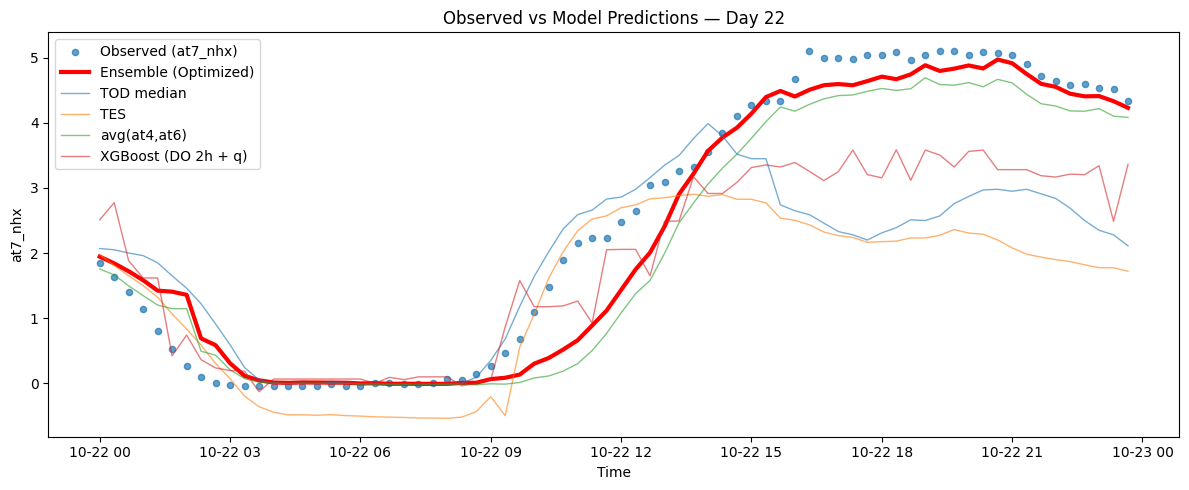

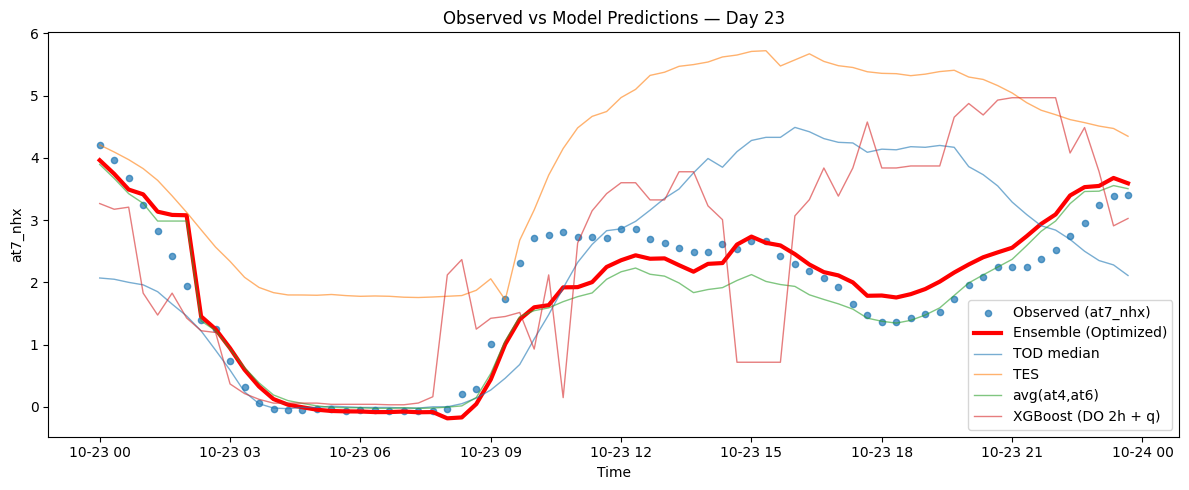

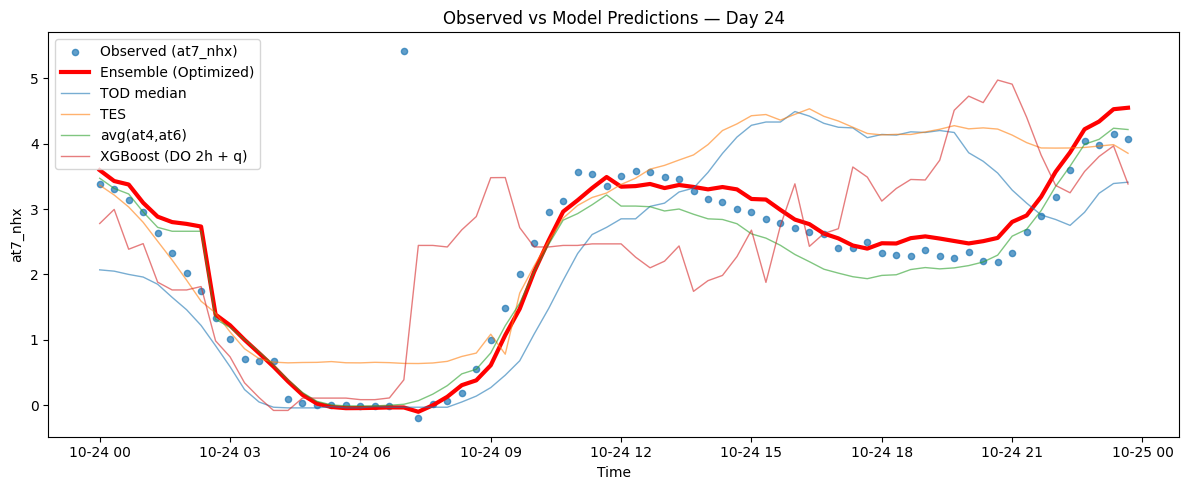

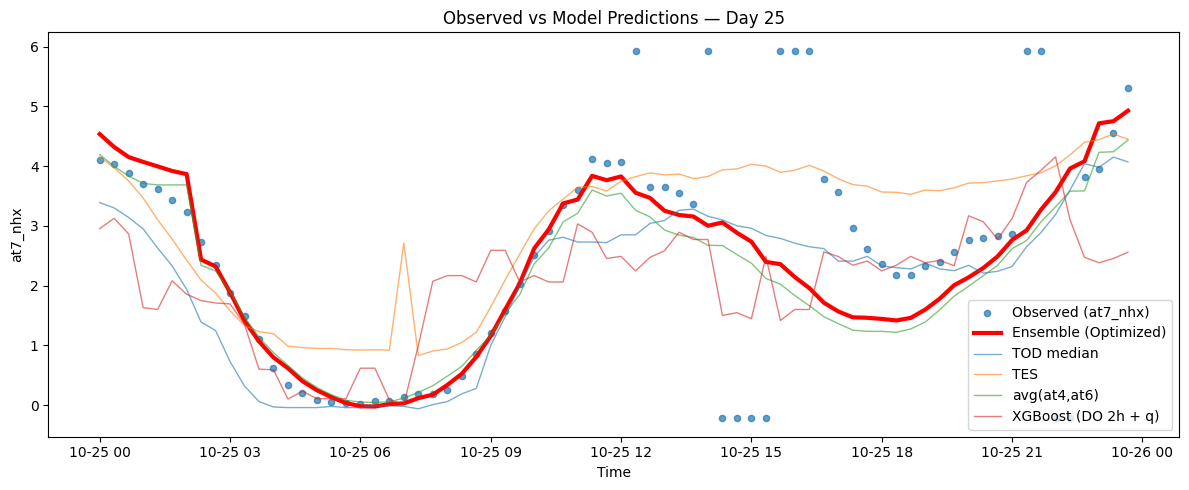


=== ENSEMBLE WEIGHTS ===
                 Model  Weight
2         avg(at4,at6)  0.9961
0           TOD median  0.1962
1                  TES -0.0313
3  XGBoost (DO 2h + q) -0.0587

=== MODEL PERFORMANCE SUMMARY ===
Type                                  Fault  Normal   Ratio
Model                                                      
Ensemble                             2.2141  0.3119  7.0986
Multivariate: avg(at4_nhx, at6_nhx)  2.3185  0.3875  5.9834
Multivariate: XGBoost                2.8003  1.7350  1.6140
Univariate: TOD median               2.2535  1.8016  1.2508
Univariate: TES                      2.3776  3.2969  0.7212


In [ ]:
if __name__ == "__main__":  # check if script is run directly
    run()  # execute the main run function
    # grid_search()  # perform grid search and create 3D plots